# Deterministic Variational Inference: Toy example
Code to accompany [**Fixing Variational Bayes: Deterministic Variational Inference for Bayesian Neural Networks**](https://arxiv.org/abs/1810.03958)

In [1]:
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os, json 

tf.enable_eager_execution()

np.random.seed(3)

In [ ]:
import gaussian_variables as gv
import utils as u
import plot_utils as pu
import bayes_layers as bnn
from bayes_models import MLP, PointMLP, AdaptedMLP
import bayes_util as bu

## Dataset

First we generate a toy dataset according to:

\begin{equation}
    y = -(x+0.5)\sin(3\pi x) + \eta
\end{equation}

Where the noise is generated according to:

\begin{equation}
    \eta = 0.45(x + 0.5)^2
\end{equation}

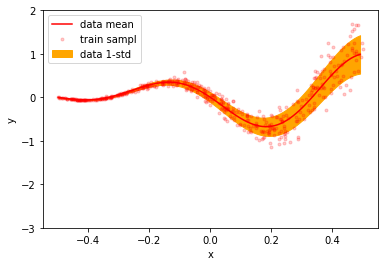

In [5]:
def base_model(x):
    return -(x+0.5)*np.sin(3 * np.pi *x)

def noise_model(x):
    return 0.45*(x+0.5)**2

def sample_data(x):
    return base_model(x) + np.random.normal(0, noise_model(x))

data_size = {'train': 500, 'valid': 100, 'test': 100}
toy_data = []
for section in ['train', 'valid', 'test']:
    x = (np.random.rand(data_size['train'], 1) - 0.5)
    toy_data.append([x, sample_data(x).reshape(-1)])    
x = np.arange(-1,1,1/100)
toy_data.append([[[_] for _ in x], base_model(x)])

pu.toy_results_plot(toy_data, {'mean':base_model, 'std':noise_model})

In [ ]:
import torch.nn as nn

In [10]:

class LinearGaussian(nn.Module):
    def __init__(self, in_features, out_features, certain=False,
                 prior="DiagonalGaussian"):
        """
        Applies linear transformation y = xA^T + b
        A and b are Gaussian random variables
        :param in_features: input dimension
        :param out_features: output dimension
        :param certain:  if false, than x is equal to its mean and has no variance
        :param prior:  prior type
        """

        super().__init__()

        self.A_mean = nn.Parameter(torch.Tensor(in_features, out_features))
        self.b_mean = nn.Parameter(torch.Tensor(out_features))
        self.certain = certain

        self.A_logvar = nn.Parameter(torch.Tensor(in_features, out_features))
        self.b_logvar = nn.Parameter(torch.Tensor(out_features))

        self.prior = prior
        self.initialize_weights()
        self.construct_priors(self.prior)
        self.use_dvi = True

    def initialize_weights(self):
        nn.init.xavier_normal_(self.A_mean)
        nn.init.normal_(self.b_mean)

        nn.init.xavier_normal_(self.A_logvar)
        nn.init.normal_(self.b_logvar)

    def construct_priors(self, prior):
        if prior == "DiagonalGaussian":
            s1 = s2 = 0.1

            self._prior_A = {
                'mean': torch.zeros_like(self.A_mean, requires_grad=False).to(2),
                'var': torch.ones_like(self.A_logvar, requires_grad=False).to(2) * s2}
            self._prior_b = {
                'mean': torch.zeros_like(self.b_mean, requires_grad=False).to(2),
                'var': torch.ones_like(self.b_logvar, requires_grad=False).to(2) * s1}
        else:
            raise NotImplementedError("{} prior is not supported".format(prior))

    def compute_kl(self):
        if self.prior == 'DiagonalGaussian':
            kl_A = KL_GG(self.A_mean, torch.exp(self.A_logvar),
                         self._prior_A['mean'].to(self.A_mean.device),
                         self._prior_A['var'].to(self.A_mean.device))
            kl_b = KL_GG(self.b_mean, torch.exp(self.b_logvar),
                         self._prior_b['mean'].to(self.A_mean.device),
                         self._prior_b['var'].to(self.A_mean.device))
        return kl_A + kl_b

    def determenistic(self, mode=True):
        self.use_dvi = True

    def mcvi(self, mode=True):
        self.use_dvi = not mode

    def get_mode(self):
        if self.use_dvi:
            print('In determenistic mode')
        else:
            print('In MCVI mode')

    def forward(self, x):
        """
        Compute expectation and variance after linear transform
        y = xA^T + b
        :param x: input, size [batch, in_features]
        :return: tuple (y_mean, y_var) for determenistic mode:,  shapes:
                 y_mean: [batch, out_features]
                 y_var:  [batch, out_features, out_features]
                 tuple (sample, None) for MCVI mode,
                 sample : [batch, out_features] - local reparametrization of output
        """
        A_var = torch.exp(self.A_logvar)
        b_var = torch.exp(self.b_logvar)
        if self.use_dvi:
            return self._det_forward(x, A_var, b_var)
        else:
            return self._mcvi_forward(x, A_var, b_var)

    def _mcvi_forward(self, x, A_var, b_var):
        if self.certain:
            x_mean = x
            x_var = None
        else:
            x_mean = x[0]
            x_var = x[1]

        y_mean = F.linear(x_mean, self.A_mean.t()) + self.b_mean

        if self.certain or not self.use_dvi:
            xx = x_mean * x_mean
            y_var = torch.diag_embed(F.linear(xx, A_var.t()) + b_var)
        else:
            y_var = self.compute_var(x_mean, x_var)

        dst = MultivariateNormal(loc=y_mean, covariance_matrix=y_var)
        sample = dst.rsample()
        return sample, None

    def _det_forward(self, x, A_var, b_var):
        """
        Compute expectation and variance after linear transform
        y = xA^T + b
        :param x: input, size [batch, in_features]
        :return: tuple (y_mean, y_var),  shapes:
                 y_mean: [batch, out_features]
                 y_var:  [batch, out_features, out_features]
        """

        if self.certain:
            x_mean = x
            x_var = None
        else:
            x_mean = x[0]
            x_var = x[1]

        y_mean = F.linear(x_mean, self.A_mean.t()) + self.b_mean

        if self.certain:
            xx = x_mean * x_mean
            y_var = torch.diag_embed(F.linear(xx, A_var.t()) + b_var)
        else:
            y_var = self.compute_var(x_mean, x_var)

        return y_mean, y_var

    def compute_var(self, x_mean, x_var):
        A_var = torch.exp(self.A_logvar)

        x_var_diag = matrix_diag_part(x_var)
        xx_mean = x_var_diag + x_mean * x_mean

        term1_diag = torch.matmul(xx_mean, A_var)

        flat_xCov = torch.reshape(x_var, (-1, self.A_mean.size(0)))  # [b*x, x]
        xCov_A = torch.matmul(flat_xCov, self.A_mean)  # [b * x, y]
        xCov_A = torch.reshape(xCov_A, (
            -1, self.A_mean.size(0), self.A_mean.size(1)))  # [b, x, y]
        xCov_A = torch.transpose(xCov_A, 1, 2)  # [b, y, x]
        xCov_A = torch.reshape(xCov_A, (-1, self.A_mean.size(0)))  # [b*y, x]

        A_xCov_A = torch.matmul(xCov_A, self.A_mean)  # [b*y, y]
        A_xCov_A = torch.reshape(A_xCov_A, (
            -1, self.A_mean.size(1), self.A_mean.size(1)))  # [b, y, y]

        term2 = A_xCov_A
        term2_diag = matrix_diag_part(term2)

        _, n, _ = term2.size()
        idx = torch.arange(0, n)

        term3_diag = torch.exp(self.b_logvar)
        result_diag = term1_diag + term2_diag + term3_diag

        result = term2
        result[:, idx, idx] = result_diag
        return result


NameError: name 'nn' is not defined

### Сheck LinearCertain

In [5]:
torch_model = LinearGaussian(1, 3, certain=True)
torch_loss = RegressionLoss(torch_model, use_heteroskedastic=False, homo_log_var_scale=1)

In [6]:
A_mean = torch_model.A_mean.detach().numpy()

A_var = torch_model.A_var.detach().numpy()

b_mean = torch_model.b_mean.detach().numpy()
b_var = torch_model.b_var.detach().numpy()

class param():
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var

A = param(A_mean, A_var)
b = param(b_mean, b_var)

In [7]:
xx = torch.FloatTensor(toy_data[0][0])

In [8]:
torch_mean, torch_var = torch_model(xx)

now tf:

In [9]:
def linear_certain_activations(x_certain, A, b):
    """
    compute y = x^T A + b
    assuming x has zero variance
    """
    x_mean = x_certain
    xx = x_mean*x_mean
    y_mean = tf.matmul(x_mean, A.mean) + b.mean
    y_cov = tf.matrix_diag(tf.matmul(xx, A.var) + b.var)
    return y_mean, y_cov


In [10]:
x  = toy_data[0][0].astype('float32')

In [11]:
tf_mean, tf_var = linear_certain_activations(x, A, b)

In [12]:
tf_mean

<tf.Tensor: id=15, shape=(500, 3), dtype=float32, numpy=
array([[ 0.91329587,  0.79197353,  0.28668857],
       [ 0.9980265 ,  0.80330646,  0.39054853],
       [ 0.77334714,  0.77325505,  0.11514421],
       ...,
       [ 0.96634424,  0.7990689 ,  0.35171345],
       [ 0.65956944,  0.758037  , -0.0243206 ],
       [ 1.0682223 ,  0.8126954 ,  0.4765921 ]], dtype=float32)>

In [13]:
torch_mean

tensor([[ 0.9133,  0.7920,  0.2867],
        [ 0.9980,  0.8033,  0.3905],
        [ 0.7733,  0.7733,  0.1151],
        ...,
        [ 0.9663,  0.7991,  0.3517],
        [ 0.6596,  0.7580, -0.0243],
        [ 1.0682,  0.8127,  0.4766]], grad_fn=<AddBackward0>)

In [14]:
tf_var

<tf.Tensor: id=21, shape=(500, 3, 3), dtype=float32, numpy=
array([[[5.8536243, 0.       , 0.       ],
        [0.       , 6.416935 , 0.       ],
        [0.       , 0.       , 4.5336475]],

       [[6.17735  , 0.       , 0.       ],
        [0.       , 6.4694743, 0.       ],
        [0.       , 0.       , 4.832366 ]],

       [[6.180491 , 0.       , 0.       ],
        [0.       , 6.469984 , 0.       ],
        [0.       , 0.       , 4.835264 ]],

       ...,

       [[6.010252 , 0.       , 0.       ],
        [0.       , 6.442355 , 0.       ],
        [0.       , 0.       , 4.678176 ]],

       [[7.237233 , 0.       , 0.       ],
        [0.       , 6.641489 , 0.       ],
        [0.       , 0.       , 5.8103747]],

       [[6.743526 , 0.       , 0.       ],
        [0.       , 6.5613623, 0.       ],
        [0.       , 0.       , 5.3548055]]], dtype=float32)>

In [15]:
torch_var

tensor([[[5.8536, 0.0000, 0.0000],
         [0.0000, 6.4169, 0.0000],
         [0.0000, 0.0000, 4.5336]],

        [[6.1774, 0.0000, 0.0000],
         [0.0000, 6.4695, 0.0000],
         [0.0000, 0.0000, 4.8324]],

        [[6.1805, 0.0000, 0.0000],
         [0.0000, 6.4700, 0.0000],
         [0.0000, 0.0000, 4.8353]],

        ...,

        [[6.0103, 0.0000, 0.0000],
         [0.0000, 6.4424, 0.0000],
         [0.0000, 0.0000, 4.6782]],

        [[7.2372, 0.0000, 0.0000],
         [0.0000, 6.6415, 0.0000],
         [0.0000, 0.0000, 5.8104]],

        [[6.7435, 0.0000, 0.0000],
         [0.0000, 6.5614, 0.0000],
         [0.0000, 0.0000, 5.3548]]], grad_fn=<CopySlices>)

### Now check Linear

In [101]:
rreg = LinearGaussian(3, 2)

In [102]:
A_mean = rreg.A_mean.detach().numpy()
A_var = rreg.A_var.detach().numpy()

b_mean = rreg.b_mean.detach().numpy()
b_var = rreg.b_var.detach().numpy()

class param():
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
        self.shape = mean.shape

A = param(A_mean, A_var)
b = param(b_mean, b_var)

In [103]:
xx = (torch_mean, torch_var)

In [104]:
xx_tf = (torch_mean.detach().numpy(), torch_var.detach().numpy())

In [105]:
torch_mean_1, torch_var_1 = rreg(xx)

In [106]:
def linear_covariance(x_mean, x_cov, A, b):
    x_var_diag = tf.matrix_diag_part(x_cov)
    xx_mean = x_var_diag + x_mean * x_mean
    
    term1_diag = tf.matmul(xx_mean, A.var)
    
    flat_xCov = tf.reshape(x_cov, [-1, A.shape[0]]) # [b*x, x]
    xCov_A = tf.matmul(flat_xCov, A.mean) # [b*x, y]
    xCov_A = tf.reshape(xCov_A, [-1, A.shape[0], A.shape[1]]) # [b, x, y]
    xCov_A = tf.transpose(xCov_A, [0, 2, 1]) # [b, y, x]
    xCov_A = tf.reshape(xCov_A, [-1, A.shape[0]]) # [b*y, x]
    A_xCov_A = tf.matmul(xCov_A, A.mean) # [b*y, y]
    A_xCov_A = tf.reshape(A_xCov_A, [-1, A.shape[1], A.shape[1]]) # [b, y, y]

    term2 = A_xCov_A
    term2_diag = tf.matrix_diag_part(term2)
    
    term3_diag = b.var
    
    result_diag = term1_diag + term2_diag + term3_diag
    return tf.matrix_set_diag(term2, result_diag)      


def linear(x, A, b):
    """
    compute y = x^T A + b
    """
    x_mean = x.mean
    y_mean = tf.matmul(x_mean, A.mean) + b.mean
    x_cov = x.var
    y_cov = linear_covariance(x_mean, x_cov, A, b)
    return y_mean, y_cov

In [107]:
tf_mean_1, tf_var_1 = linear(param(xx_tf[0], xx_tf[1]), A, b)

(500, 2, 2)


In [108]:
torch_mean_1[:10]

tensor([[1.2008, 0.9447],
        [1.2895, 1.0223],
        [1.0544, 0.8165],
        [1.1783, 0.9250],
        [1.3936, 1.1135],
        [1.3955, 1.1151],
        [0.9612, 0.7349],
        [1.0073, 0.7752],
        [0.9195, 0.6984],
        [1.1389, 0.8904]], grad_fn=<SliceBackward>)

In [109]:
tf_mean_1[:10]

<tf.Tensor: id=337, shape=(10, 2), dtype=float32, numpy=
array([[1.2008369 , 0.9447069 ],
       [1.2894974 , 1.0223311 ],
       [1.0543975 , 0.8164957 ],
       [1.1783154 , 0.9249886 ],
       [1.3936245 , 1.1134968 ],
       [1.39551   , 1.1151475 ],
       [0.96124655, 0.73493993],
       [1.0072572 , 0.77522343],
       [0.9194839 , 0.6983758 ],
       [1.1388631 , 0.8904473 ]], dtype=float32)>

In [110]:
torch_var_1[:3]

tensor([[[39.2456,  2.9597],
         [ 2.9597, 32.7805]],

        [[40.9367,  3.0715],
         [ 3.0715, 34.0926]],

        [[40.1750,  3.0726],
         [ 3.0726, 33.2175]]], grad_fn=<SliceBackward>)

In [111]:
tf_var_1[:3]

<tf.Tensor: id=342, shape=(3, 2, 2), dtype=float32, numpy=
array([[[39.245625 ,  2.959738 ],
        [ 2.959738 , 32.78047  ]],

       [[40.936665 ,  3.0714676],
        [ 3.0714676, 34.0926   ]],

       [[40.17499  ,  3.0725517],
        [ 3.0725517, 33.21749  ]]], dtype=float32)>

# Check Regression Loss

### torch

In [982]:
import torch
import torch.nn as nn
import torch.nn.functional as F


EPS = 1e-8


def matrix_diag_part(tensor):
    return torch.stack(tuple(t.diag() for t in torch.unbind(tensor, 0)))


class LinearGaussian(nn.Module):
    def __init__(self, in_features, out_features, certain=False,
                 prior="DiagonalGaussian"):
        """
        Applies linear transformation y = xA^T + b

        A and b are Gaussian random variables

        :param in_features: input dimension
        :param out_features: output dimension
        :param certain:  if false, than x is equal to its mean and has no variance
        :param prior:  prior type
        """

        super().__init__()

        self.A_mean = nn.Parameter(torch.Tensor(in_features, out_features))
        self.b_mean = nn.Parameter(torch.Tensor(out_features))
        self.certain = certain

        self.A_var = nn.Parameter(torch.Tensor(in_features, out_features))
        self.b_var = nn.Parameter(torch.Tensor(out_features))

        self.prior = prior
        self.initialize_weights()
        self.construct_priors(self.prior)

    def initialize_weights(self):
        nn.init.zeros_(self.A_mean)
        nn.init.zeros_(self.b_mean)

        shape = self.b_var.size(0)
        s = shape * shape

        nn.init.uniform_(self.A_var, a=0, b=s)
        nn.init.uniform_(self.b_var, a=0, b=s)

    def construct_priors(self, prior):
        if prior == "DiagonalGaussian":
            s1 = 1
            s2 = 1

            self._prior_A = {
                'mean': torch.zeros_like(self.A_mean, requires_grad=False),
                'var': torch.ones_like(self.A_var, requires_grad=False) * s2}
            self._prior_b = {
                'mean': torch.zeros_like(self.b_mean, requires_grad=False),
                'var': torch.ones_like(self.b_var, requires_grad=False) * s1}
        else:
            raise NotImplementedError("{} prior is not supported".format(prior))

    def compute_kl(self):
        if self.prior == 'DiagonalGaussian':
            kl_A = KL_GG(self.A_mean, self.A_var, self._prior_A['mean'],
                         self._prior_A['var'])
            kl_b = KL_GG(self.b_mean, self.b_var, self._prior_b['mean'],
                         self._prior_b['var'])
        return kl_A + kl_b

    def forward(self, x):
        """
        Compute expectation and variance after linear transform
        y = xA^T + b

        :param x: input, size [batch, in_features]
        :return: tuple (y_mean, y_var),  shapes:
                 y_mean: [batch, out_features]
                 y_var:  [batch, out_features, out_features]
        """

        if self.certain:
            x_mean = x
            x_var = None
        else:
            x_mean = x[0]
            x_var = x[1]

        y_mean = F.linear(x_mean, self.A_mean.t()) + self.b_mean

        if self.certain:
            xx = x_mean * x_mean
            y_var = torch.diag_embed(F.linear(xx, self.A_var.t()) + self.b_var)
        else:
            y_var = self.compute_var(x_mean, x_var)

        return y_mean, y_var

    def compute_var(self, x_mean, x_var):
        x_var_diag = matrix_diag_part(x_var)
        xx_mean = x_var_diag + x_mean * x_mean

        term1_diag = torch.matmul(xx_mean, self.A_var)

        flat_xCov = torch.reshape(x_var, (-1, self.A_mean.size(0)))  # [b*x, x]
        xCov_A = torch.matmul(flat_xCov, self.A_mean)  # [b * x, y]
        xCov_A = torch.reshape(xCov_A, (
            -1, self.A_mean.size(0), self.A_mean.size(1)))  # [b, x, y]
        xCov_A = torch.transpose(xCov_A, 1, 2)  # [b, y, x]
        xCov_A = torch.reshape(xCov_A, (-1, self.A_mean.size(0)))  # [b*y, x]

        A_xCov_A = torch.matmul(xCov_A, self.A_mean)  # [b*y, y]
        A_xCov_A = torch.reshape(A_xCov_A, (
            -1, self.A_mean.size(1), self.A_mean.size(1)))  # [b, y, y]

        term2 = A_xCov_A
        term2_diag = matrix_diag_part(term2)

        _, n, _ = term2.size()
        idx = torch.arange(0, n)

        term3_diag = self.b_var
        result_diag = term1_diag + term2_diag + term3_diag

        result = term2
        result[:, idx, idx] = result_diag
        return result


In [991]:

class RegressionLoss(nn.Module):
    def __init__(self, net, method='bayes', use_heteroskedastic=False,
                 homo_log_var_scale=1.):
        """
        Compute ELBO for regression task

        :param net: neural network
        :param method:
        :param use_heteroskedastic:
        :param homo_log_var_scale:
        """
        super().__init__()

        self.net = net
        self.method = method
        self.use_het = use_heteroskedastic
        if not self.use_het and homo_log_var_scale is None:
            raise ValueError(
                "homo_log_var_scale must be set in homoskedastic mode")

        if self.use_het:
            raise NotImplementedError("heterostadic is not supported yet")

        self.homo_log_var_scale = homo_log_var_scale

    def gaussian_likelihood_core(self, target, mean, log_var, smm, sml, sll):
        const = math.log(2 * math.pi)
        exp = torch.exp(-log_var + 0.5 * sll)
        return -0.5 * (const + log_var + exp * (smm + (mean - sml - target) ** 2))

    def heteroskedastic_gaussian_loglikelihood(self, pred_mean, pred_var,
                                               target):
        log_var = pred_mean[:, 1].view(-1)
        mean = pred_mean[:, 0].view(-1)

        if self.method.lower() == 'bayes':
            sll = pred_var[:, 1, 1].view(-1)
            smm = pred_var[:, 0, 0].view(-1)
            sml = pred_var[:, 0, 1].view(-1)
        else:
            sll = smm = sml = 0
        return self.gaussian_likelihood_core(target, mean, log_var, smm, sml,
                                             sll)

    def homoskedastic_gaussian_loglikelihood(self, pred_mean, pred_var, target):
        log_var = torch.FloatTensor([self.homo_log_var_scale], device=pred_mean.device)
        mean = pred_mean[:, 0].view(-1)
        sll = sml = 0
        if self.method.lower() == 'bayes':
            smm = pred_var[:, 0, 0].view(-1)
        else:
            smm = 0
        return self.gaussian_likelihood_core(target, mean, log_var, smm, sml,
                                         sll)

    def forward(self, pred, target):
        pred_mean = pred[0]
        pred_var = pred[1]

        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'compute_kl'):
                kl = kl + module.compute_kl()
        if hasattr(self.net, 'compute_kl'):
            kl = kl + self.net.compute_kl()

        gaussian_likelihood = self.heteroskedastic_gaussian_loglikelihood if self.use_het \
            else self.homoskedastic_gaussian_loglikelihood

        log_likelihood = gaussian_likelihood(pred_mean, pred_var, target)
        batched_likelihood = torch.mean(log_likelihood)

        loss = kl - batched_likelihood
        return loss, batched_likelihood.detach(), kl


In [992]:
torch_reg = LinearGaussian(2, 1)

In [993]:
A_mean = torch_reg.A_mean.detach().numpy()
A_var = torch_reg.A_var.detach().numpy()

b_mean = torch_reg.b_mean.detach().numpy()
b_var = torch_reg.b_var.detach().numpy()

class param():
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
        self.shape = mean.shape

A = param(A_mean, A_var)
b = param(b_mean, b_var)

In [994]:
torch_pred = torch_reg((torch_mean_1, torch_var_1))

In [995]:
target = torch.FloatTensor(toy_data[0][1])

In [996]:
criterion = RegressionLoss(torch_reg)

In [997]:
loss = criterion(torch_pred, target)

In [998]:
loss

(tensor(8.7631, grad_fn=<SubBackward0>),
 tensor(-8.2606),
 tensor(0.5024, grad_fn=<AddBackward0>))

### tf:

In [999]:
tf_mean, tf_var = linear(param(tf_mean_1, tf_var_1), A, b)

(500, 1, 1)


In [1000]:
torch_pred[1][:3]

tensor([[[34.9562]],

        [[36.5441]],

        [[35.4090]]], grad_fn=<SliceBackward>)

In [1001]:
tf_var[:3]

<tf.Tensor: id=4177, shape=(3, 1, 1), dtype=float32, numpy=
array([[[34.956158]],

       [[36.544125]],

       [[35.409035]]], dtype=float32)>

In [1002]:
class DiagonalGaussianVar(object):
    def __init__(self, mean, var, shape=None):
        self.mean = mean
        self.var = var
        self.shape = tf.shape(mean) if shape is None else shape
    
    def sample(self, n_sample=None):
        no_sample_dim = False
        if n_sample is None:
            no_sample_dim = True
            n_sample = 1
        s = tf.random_normal(shape=tf.concat([[n_sample], self.shape], axis=0)) * tf.sqrt(self.var) + self.mean
        if no_sample_dim:
            return s[0,...]
        else:
            return s

    def log_likelihood(self, x):
        return -0.5 * (bu.log2pi + tf.log(self.var) + (x - self.mean)**2 / self.var)

    
def KL(p, q, hypers=None, global_step=1.0E99):
    safe_qvar = q.var + bu.EPSILON
    entropy_term = 0.5 * (1 + bu.log2pi + tf.log(p.var))

    cross_entropy_term = 0.5 * (bu.log2pi + tf.log(safe_qvar) + (p.var + (p.mean - q.mean)**2) / safe_qvar)           
    return tf.reduce_sum(cross_entropy_term - entropy_term)

class Parameter(object):
    def __init__(self, value, prior, variables=None):
        self.value = value
        self.prior = prior
        self.variables = variables
    
    def surprise(self, hypers=None, global_step=1.0E99):
        """
        compute KL(value || prior) 
        assuming
            (1) diagonal gaussian value
            (2) diagonal gaussian prior with scalar mu, var
        """
        return KL(self.value, self.prior, hypers, global_step)

    def log_likelihood(self):
        return tf.reduce_sum(self.prior.log_likelihood(self.value.mean))

    def standardize(self):
        return DiagonalGaussianVar(
            (self.value.mean - self.prior.mean) / np.sqrt(self.prior.var),
            self.value.var / self.prior.var)


In [1003]:
def heteroskedastic_gaussian_loglikelihood(pred, target, global_step, hypers):
    log_variance = tf.reshape(pred.mean[:,1], [-1])
    mean = tf.reshape(pred.mean[:,0], [-1])
    if hypers['method'].lower().strip() == 'bayes':
        sll = tf.reshape(pred.var[:,1,1], [-1])
        smm = tf.reshape(pred.var[:,0,0], [-1])
        sml = tf.reshape(pred.var[:,0,1], [-1])
    else:
        sll = smm = sml = tf.constant(0.0, dtype=tf.float32)
    return gaussian_loglikelihood_core(target, mean, log_variance, smm, sml, sll)

def homoskedastic_gaussian_loglikelihood(pred, target, global_step, hypers):
    log_variance = tf.constant(hypers["homo_logvar_scale"], dtype=tf.float32)
    mean = tf.reshape(pred.mean[:,0], [-1])
    sll = tf.constant(0.0, dtype=tf.float32)
    sml = tf.constant(0.0, dtype=tf.float32)
    if hypers['method'].lower().strip() == 'bayes':
        smm = tf.reshape(pred.var[:,0,0], [-1])
    else:
        smm = tf.constant(0.0, dtype=tf.float32)
    return gaussian_loglikelihood_core(target, mean, log_variance, smm, sml, sll)

def gaussian_loglikelihood_core(target, mean, log_variance, smm, sml, sll):
    
    return -0.5 * (
        bu.log2pi 
        + log_variance
        + tf.exp(-log_variance + 0.5*sll)
          * (smm + (mean - sml - target)**2)
    )

def regression_loss(pred, target, model, hypers, global_step):
    all_surprise = tf.reduce_sum(tf.stack([w.surprise(hypers, global_step) for w in model.parameters]))
    gaussian_loglikelihood = (     heteroskedastic_gaussian_loglikelihood 
                              if   hypers['style'] == 'heteroskedastic' 
                              else homoskedastic_gaussian_loglikelihood)
    log_likelihood = gaussian_loglikelihood(pred, target, global_step, hypers)
    batch_log_likelihood = tf.reduce_mean(log_likelihood)
    L =  all_surprise - batch_log_likelihood
    return L, batch_log_likelihood, all_surprise


##### распределения

In [1004]:
prior_A = DiagonalGaussianVar(tf.zeros_like(A.mean, dtype=tf.float32), 
                              tf.ones_like(A.var, dtype=tf.float32))

prior_b = DiagonalGaussianVar(tf.zeros_like(b.mean, dtype=tf.float32),
                             tf.ones_like(b.var, dtype=tf.float32))

In [1005]:
out_dst = DiagonalGaussianVar(tf_mean, tf_var)

In [1006]:
value_A = DiagonalGaussianVar(A.mean, A.var)
value_b = DiagonalGaussianVar(b.mean, b.var)

In [1007]:
param_A = Parameter(value_A, prior_A)
param_b = Parameter(value_b, prior_b)

In [1008]:
hypers = {}
hypers['style'] = 'homosked'
hypers["homo_logvar_scale"] = 1.
hypers['method'] = 'bayes'

In [1009]:
class model():
    def __init__(self, params):
        self.parameters = params

In [1010]:
tf_model = model([param_A, param_b])

In [1011]:
tf_pred = param(tf_mean, tf_var)

In [1012]:
regression_loss(tf_pred, toy_data[0][1], tf_model, hypers, 1.)

(<tf.Tensor: id=4264, shape=(), dtype=float32, numpy=8.763061>,
 <tf.Tensor: id=4263, shape=(), dtype=float32, numpy=-8.260625>,
 <tf.Tensor: id=4236, shape=(), dtype=float32, numpy=0.5024353>)

#### check KL

In [862]:
torch_reg.b_mean, torch_reg.b_var

(Parameter containing:
 tensor([0.], requires_grad=True), Parameter containing:
 tensor([0.3284], requires_grad=True))

In [863]:
b.mean, b.var

(array([0.], dtype=float32), array([0.3283553], dtype=float32))

In [864]:
prior_b.mean, prior_b.var

(<tf.Tensor: id=3457, shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: id=3460, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)

In [870]:
def KL(p, q, hypers=None, global_step=1.0E99):
    safe_qvar = q.var + bu.EPSILON
    entropy_term = 0.5 * (1 + bu.log2pi + tf.log(p.var))
    
    
    cross_entropy_term = 0.5 * (bu.log2pi + tf.log(safe_qvar) + (p.var + (p.mean - q.mean)**2) / safe_qvar) 
    return tf.reduce_sum(cross_entropy_term - entropy_term)


def KL_GG(p_mean, p_var, q_mean, q_var):
    """
    Computes KL (p || q) from p to q, assuming that both p and q have normal
    distribution

    :param p_mean:
    :param p_var:
    :param q_mean:
    :param q_var:
    :return:
    """
    s_q_var = q_var + EPS
    entropy = 0.5 * (1 + np.log(2 * np.pi) + torch.log(p_var))
    
    
    cross_entropy = 0.5 * (math.log(2 * math.pi) + torch.log(s_q_var) + \
                           (p_var + (p_mean - q_mean) ** 2) / s_q_var)
    return torch.sum(cross_entropy - entropy)


In [871]:
KL(value_b, prior_b)

<tf.Tensor: id=3601, shape=(), dtype=float32, numpy=0.22100753>

In [872]:
KL_GG(torch_reg.b_mean, torch_reg.b_var, torch_reg._prior_b['mean'], torch_reg._prior_b['var'])

tensor(0.2210, grad_fn=<SumBackward0>)

In [875]:
KL(value_A, prior_A)

<tf.Tensor: id=3641, shape=(), dtype=float32, numpy=0.13841438>

In [876]:
KL_GG(torch_reg.A_mean, torch_reg.A_var, torch_reg._prior_A['mean'], torch_reg._prior_A['var'])

tensor(0.1384, grad_fn=<SumBackward0>)

#### checl likelihood

In [877]:
hypers

{'homo_logvar_scale': 1.0, 'method': 'bayes', 'style': 'homosked'}

In [943]:
def heteroskedastic_gaussian_loglikelihood_tf(pred, target, global_step, hypers):
    log_variance = tf.reshape(pred.mean[:,1], [-1])
    mean = tf.reshape(pred.mean[:,0], [-1])
    if hypers['method'].lower().strip() == 'bayes':
        sll = tf.reshape(pred.var[:,1,1], [-1])
        smm = tf.reshape(pred.var[:,0,0], [-1])
        sml = tf.reshape(pred.var[:,0,1], [-1])
    else:
        sll = smm = sml = tf.constant(0.0, dtype=tf.float32)
    return gaussian_loglikelihood_core_tf(target, mean, log_variance, smm, sml, sll)

def homoskedastic_gaussian_loglikelihood_tf(pred, target, global_step, hypers):
    log_variance = tf.constant(hypers["homo_logvar_scale"], dtype=tf.float32)
    mean = tf.reshape(pred.mean[:,0], [-1])
    sll = tf.constant(0.0, dtype=tf.float32)
    sml = tf.constant(0.0, dtype=tf.float32)
    if hypers['method'].lower().strip() == 'bayes':
        smm = tf.reshape(pred.var[:,0,0], [-1])
    else:
        smm = tf.constant(0.0, dtype=tf.float32)
    return gaussian_loglikelihood_core_tf(target, mean, log_variance, smm, sml, sll)

def gaussian_loglikelihood_core_tf(target, mean, log_variance, smm, sml, sll):
    return -0.5 * (
        bu.log2pi 
        + log_variance
        + tf.exp(-log_variance + 0.5*sll)
          * (smm + (mean - sml - target)**2)
    )

In [944]:
class test_ll():
    def __init__(self, method, logvar_scale):
        self.method = method
        self.logvar_scale = logvar_scale
        
    def gaussian_likelihood_core(self, target, mean, log_var, smm, sml, sll):
        const = math.log(2 * math.pi)
        exp = torch.exp(-log_var + 0.5 * sll)
        return -0.5 * (const + log_var + exp * (smm + (mean - sml - target) ** 2))

    def heteroskedastic_gaussian_loglikelihood(self, pred_mean, pred_var,
                                               target):
        log_var = pred_mean[:, 1].view(-1)
        mean = pred_mean[:, 0].view(-1)

        if self.method.lower() == 'bayes':
            sll = pred_var[:, 1, 1].view(-1)
            smm = pred_var[:, 0, 0].view(-1)
            sml = pred_var[:, 0, 1].view(-1)
        else:
            sll = smm = sml = 0
        return self.gaussian_likelihood_core(target, mean, log_var, smm, sml,
                                             sll)

    def homoskedastic_gaussian_loglikelihood(self, pred_mean, pred_var, target):
        log_var = torch.FloatTensor([self.logvar_scale], device=pred_mean.device)
        mean = pred_mean[:, 0].view(-1)
        sll = sml = 0
        if self.method.lower() == 'bayes':
            smm = pred_var[:, 0, 0].view(-1)
        else:
            smm = 0
        return self.gaussian_likelihood_core(target, mean, log_var, smm, sml,
                                         sll)


In [945]:
ll_tester = test_ll('bayes', logvar_scale=1)

In [949]:
ll_tester.homoskedastic_gaussian_loglikelihood(torch_pred[0], torch_pred[1], torch.FloatTensor(toy_data[0][1]))[341:347]

tensor([-11.6795,  -9.9893, -10.0081, -10.9889, -10.0269,  -9.9133],
       grad_fn=<SliceBackward>)

In [950]:
homoskedastic_gaussian_loglikelihood_tf(tf_pred, toy_data[0][1], 1e98, hypers)[341:347]

<tf.Tensor: id=4022, shape=(6,), dtype=float32, numpy=
array([-11.679482,  -9.989309, -10.008125, -10.988946, -10.026949,
        -9.913277], dtype=float32)>

## ReLU

In [4]:
import tensorflow as tf
import numpy as np
import utils as u
import bayes_util as bu
import gaussian_variables as gv

EPSILON = 1e-6


def linear(x, A, b):
    """
    compute y = x^T A + b
    """
    x_mean = x.mean
    y_mean = tf.matmul(x_mean, A.mean) + b.mean
    x_cov = x.var
    y_cov = linear_covariance(x_mean, x_cov, A, b)
    return gv.GaussianVar(y_mean, y_cov)

def linear_certain_activations(x_certain, A, b):
    """
    compute y = x^T A + b
    assuming x has zero variance
    """
    x_mean = x_certain
    xx = x_mean*x_mean
    y_mean = tf.matmul(x_mean, A.mean) + b.mean
    y_cov = tf.matrix_diag(tf.matmul(xx, A.var) + b.var)
    return y_mean, y_cov

def linear_relu(x, A, b):
    """
    compute y = relu(x)^T A + b
    """
    x_var_diag = tf.matrix_diag_part(x.var)
    sqrt_x_var_diag = tf.sqrt(x_var_diag)
    mu = x.mean / (sqrt_x_var_diag + EPSILON)
    
    def relu_covariance(x):
        mu1 = tf.expand_dims(mu, 2)
        mu2 = tf.transpose(mu1, [0,2,1])

        s11s22 = tf.expand_dims(x_var_diag, axis=2) * tf.expand_dims(x_var_diag, axis=1)
        rho = x.var / (tf.sqrt(s11s22))# + EPSILON)
        rho = tf.clip_by_value(rho, -1/(1+EPSILON), 1/(1+EPSILON))

        return x.var * bu.delta(rho, mu1, mu2)   
    
    z_mean = sqrt_x_var_diag * bu.softrelu(mu)
    y_mean = tf.matmul(z_mean, A.mean) + b.mean
    z_cov = relu_covariance(x)
    y_cov = linear_covariance(z_mean, z_cov, A, b)
    return y_mean, y_cov

def linear_relu_diagonal(x, A, b):
    """
    compute y = relu(x)^T A + b
    """
    x_var_diag = x.var
    sqrt_x_var_diag = tf.sqrt(x_var_diag)
    mu = x.mean / (sqrt_x_var_diag + EPSILON)
    
    pdf = bu.standard_gaussian(mu) 
    cdf = bu.gaussian_cdf(mu)
    softrelu = pdf + mu*cdf
    
    z_mean = sqrt_x_var_diag * softrelu
    y_mean = tf.matmul(z_mean, A.mean) + b.mean
    z_var = x_var_diag * (cdf + mu*softrelu - tf.square(softrelu))
    y_cov = linear_covariance_diagonal(z_mean, z_var, A, b)
    return y_mean, y_cov

def simple(x, A, b):
    mu = x.mean
    y_mean = tf.matmul(mu, A.mean) + b.mean    
    y_cov = x.var
    return gv.GaussianVar(y_mean, y_cov)


def linear_heaviside(x, A, b):
    """
    compute y = heaviside(x)^T A + b
    """
    x_var_diag = tf.matrix_diag_part(x.var)
    mu = x.mean / (tf.sqrt(x_var_diag) + EPSILON)
    
    def heaviside_covariance(x):
        mu1 = tf.expand_dims(mu, 2)
        mu2 = tf.transpose(mu1, [0,2,1])

        s11s22 = tf.expand_dims(x_var_diag, axis=2) * tf.expand_dims(x_var_diag, axis=1)
        rho = x.var / (tf.sqrt(s11s22))# + EPSILON)
        rho = tf.clip_by_value(rho, -1/(1+EPSILON), 1/(1+EPSILON))

        return bu.heavy_g(rho, mu1, mu2)
    
    z_mean = bu.gaussian_cdf(mu)
    y_mean = tf.matmul(z_mean, A.mean) + b.mean
    z_cov = heaviside_covariance(x)
    y_cov = linear_covariance(z_mean, z_cov, A, b)
    return y_mean, y_cov

def linear_covariance_diagonal(x_mean, x_var, A, b):
    xx_mean = x_var + x_mean * x_mean
    term1_diag = tf.matmul(xx_mean, A.var)
    Asqr = tf.square(A.mean)
    A_xCov_A = tf.matmul(x_var, Asqr)
    term2_diag = A_xCov_A
    term3_diag = b.var
    result_diag = term1_diag + term2_diag + term3_diag
    return result_diag

def linear_covariance(x_mean, x_cov, A, b):
    x_var_diag = tf.matrix_diag_part(x_cov)
    xx_mean = x_var_diag + x_mean * x_mean
    
    term1_diag = tf.matmul(xx_mean, A.var)
    
    flat_xCov = tf.reshape(x_cov, [-1, A.shape[0]]) # [b*x, x]
    xCov_A = tf.matmul(flat_xCov, A.mean) # [b*x, y]
    xCov_A = tf.reshape(xCov_A, [-1, A.shape[0], A.shape[1]]) # [b, x, y]
    xCov_A = tf.transpose(xCov_A, [0, 2, 1]) # [b, y, x]
    xCov_A = tf.reshape(xCov_A, [-1, A.shape[0]]) # [b*y, x]
    A_xCov_A = tf.matmul(xCov_A, A.mean) # [b*y, y]
    A_xCov_A = tf.reshape(A_xCov_A, [-1, A.shape[1], A.shape[1]]) # [b, y, y]

    term2 = A_xCov_A
    term2_diag = tf.matrix_diag_part(term2)
    
    term3_diag = b.var
    
    result_diag = term1_diag + term2_diag + term3_diag
    return tf.matrix_set_diag(term2, result_diag)      

def logsumexp(y, keepdims=False):
    """
    compute <logsumexp(y)>
    """
    lse = tf.reduce_logsumexp(y.mean, axis=-1, keep_dims=keepdims)   # [b, 1]
    p = tf.exp(y.mean - lse)  # softmax                              # [b, y]
    pTDiagVar = tf.reduce_sum(p * tf.matrix_diag_part(y.var), axis=-1, keep_dims=keepdims)        # [b, 1]
    pTVarp = tf.squeeze(tf.matmul(tf.expand_dims(p, 1), tf.matmul(y.var, tf.expand_dims(p, 2))), axis=-1) # [b]
    return lse + 0.5 * (pTDiagVar - pTVarp)

def logsoftmax(y):
    """
    compute <logsoftmax(y)>
    """
    return y.mean - logsumexp(y, keepdims=True) # [b, y]

def categorical_loss(logits, target, model, hypers, global_step, MC_samples=-1):
    """
    compute <p(D|w)>_q - lambda KL(q || p)
    """
    lsm = tf.cond(tf.greater(MC_samples, 0),
        lambda: sampled_logsoftmax(logits, MC_samples), # we evaluate the logsoftmax using MC sampling
        lambda: logsoftmax(logits)                      # we evaluate the logsoftmax using the delta approx
    )

    all_surprise = tf.reduce_sum(tf.stack([w.surprise() for w in model.parameters]))
    logprob = tf.reduce_sum(target * lsm, axis=1)
    batch_logprob = tf.reduce_mean(logprob)
    
    lmda = hypers['lambda']
    
    L = lmda * all_surprise / hypers['dataset_size'] - batch_logprob
    return L, batch_logprob, all_surprise

def heteroskedastic_gaussian_loglikelihood(pred, target, global_step, hypers):
    log_variance = tf.reshape(pred.mean[:,1], [-1])
    mean = tf.reshape(pred.mean[:,0], [-1])
    if hypers['method'].lower().strip() == 'bayes':
        sll = tf.reshape(pred.var[:,1,1], [-1])
        smm = tf.reshape(pred.var[:,0,0], [-1])
        sml = tf.reshape(pred.var[:,0,1], [-1])
    else:
        sll = smm = sml = tf.constant(0.0, dtype=tf.float32)
    return gaussian_loglikelihood_core(target, mean, log_variance, smm, sml, sll)

def homoskedastic_gaussian_loglikelihood(pred, target, global_step, hypers):
    log_variance = tf.constant(hypers["homo_logvar_scale"], dtype=tf.float32)
    mean = tf.reshape(pred.mean[:,0], [-1])
    sll = tf.constant(0.0, dtype=tf.float32)
    sml = tf.constant(0.0, dtype=tf.float32)
    if hypers['method'].lower().strip() == 'bayes':
        smm = tf.reshape(pred.var[:,0,0], [-1])
    else:
        smm = tf.constant(0.0, dtype=tf.float32)
    return gaussian_loglikelihood_core(target, mean, log_variance, smm, sml, sll)

def gaussian_loglikelihood_core(target, mean, log_variance, smm, sml, sll):
    return -0.5 * (
        bu.log2pi 
        + log_variance
        + tf.exp(-log_variance + 0.5*sll)
          * (smm + (mean - sml - target)**2)
    )

def regression_loss(pred, target, model, hypers, global_step):
    all_surprise = tf.reduce_sum(tf.stack([w.surprise(hypers, global_step) for w in model.parameters]))
    gaussian_loglikelihood = (     heteroskedastic_gaussian_loglikelihood 
                              if   hypers['style'] == 'heteroskedastic' 
                              else homoskedastic_gaussian_loglikelihood)
    log_likelihood = gaussian_loglikelihood(pred, target, global_step, hypers)
    batch_log_likelihood = tf.reduce_mean(log_likelihood)
    lmda = u.piecewise_anneal(hypers, 'lambda', global_step)
    L = lmda * all_surprise / hypers['dataset_size'] - batch_log_likelihood
    return L, batch_log_likelihood, all_surprise

def point_catagorical_loss(logits, target, model, hypers, global_step, MC_samples=-1):
    logprob = -tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=target))
    return -logprob, logprob, tf.constant(0.0, dtype=tf.float32)

def point_regression_loss(pred, target, model, hypers, global_step):
    gaussian_loglikelihood = (     heteroskedastic_gaussian_loglikelihood 
                          if   hypers['style'] == 'heteroskedastic' 
                          else homoskedastic_gaussian_loglikelihood)
    log_likelihood = gaussian_loglikelihood(pred, target, global_step, hypers)
    batch_log_likelihood = tf.reduce_mean(log_likelihood)
    if hypers['method'].lower().strip() == 'map':
        all_LL = tf.reduce_sum(tf.stack([w.log_likelihood() for w in model.parameters]))
        lmda = u.piecewise_anneal(hypers, 'lambda', global_step)
        L = -lmda * all_LL / hypers['dataset_size'] - batch_log_likelihood
    else:
        all_LL = tf.constant(0)
        L = -batch_log_likelihood
    return L, batch_log_likelihood, all_LL

def sample_activations(acts, n_sample):
    """
    take n_sample samples from acts
    input: acts: GaussianVar [batch_size (b), hidden size (h)]
    """
    sigma_sqr = acts.var                                          # [b, h, h]
    sigma = tf.transpose(tf.cholesky(sigma_sqr), [0,2,1])         # [b, h, h]
    standard_samples = tf.random_normal(
        [tf.shape(sigma)[0], n_sample, tf.shape(sigma)[-1]])      # [b, n_sample, h]
    samples = tf.matmul(standard_samples, sigma) + tf.expand_dims(acts.mean, 1) # [b, n_sample, h]
    return samples

def sampled_logsoftmax(logits, n_sample):
    samples = sample_activations(logits, n_sample)         # [b, n_sample, h]
    softmax_samples = tf.nn.softmax(samples, dim=-1)       # [b, n_sample, h]
    mean_softmax = tf.reduce_mean(softmax_samples, axis=1) # [b, h]
    return tf.log(mean_softmax)

In [5]:
import torch
from torch import nn

In [6]:
import torch
import numpy as np
import math

EPS = 1e-8


def standard_gaussian(x):
    return torch.exp(-1 / 2 * x * x) / np.sqrt(2 * math.pi)


def gaussian_cdf(x):
    const = 1 / np.sqrt(2)
    return 0.5 * (1 + torch.erf(x * const))


def softrelu(x):
    return standard_gaussian(x) + x * gaussian_cdf(x)


def heaviside_q(rho, mu1, mu2):
    """
    Compute exp ( -Q(rho, mu1, mu2) ) for Heaviside activation

    """
    rho_hat = torch.sqrt(1 - rho * rho)
    arcsin = torch.asin(rho)

    rho_s = torch.abs(rho) + EPS
    arcsin_s = torch.abs(torch.asin(rho)) + EPS

    A = arcsin / (2 * math.pi)
    coef = rho_s / (2 * arcsin_s * rho_hat)
    coefs_prod = (rho * rho) / (arcsin_s * rho_hat * (1 + rho_hat))
    return A * torch.exp( -(mu1 * mu1 + mu2 * mu2) * coef + mu1 * mu2 * coefs_prod)


def relu_q(rho, mu1, mu2):
    """
    Compute exp ( -Q(rho, mu1, mu2) ) for ReLU activation

    """
    rho_hat_plus_one = torch.sqrt(1 - rho * rho) + 1
    g_r = torch.asin(rho) - rho / rho_hat_plus_one  # why minus?

    rho_s = torch.abs(rho) + EPS
    g_r_s = torch.abs(g_r) + EPS
    A = g_r / (2 * math.pi)

    coef_sum = rho_s / (2 * g_r_s * rho_hat_plus_one)
    coef_prod = (torch.asin(rho) - rho) / (rho_s * g_r_s)
    return A * torch.exp(
        - (mu1 * mu1 + mu2 * mu2) * coef_sum + coef_prod * mu1 * mu2)


def delta(rho, mu1, mu2):
    return gaussian_cdf(mu1) * gaussian_cdf(mu2) + relu_q(rho, mu1, mu2)


def KL_GG(p_mean, p_var, q_mean, q_var):
    """
    Computes KL (p || q) from p to q, assuming that both p and q have normal
    distribution

    :param p_mean:
    :param p_var:
    :param q_mean:
    :param q_var:
    :return:
    """
    s_q_var = q_var + EPS
    entropy = 0.5 * (1 + math.log(2 * math.pi) + torch.log(p_var))
    cross_entropy = 0.5 * (math.log(2 * math.pi) + torch.log(s_q_var) + \
                           (p_var + (p_mean - q_mean) ** 2) / s_q_var)
    return torch.sum(cross_entropy - entropy)



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

EPS = 1e-8


def matrix_diag_part(tensor):
    return torch.stack(tuple(t.diag() for t in torch.unbind(tensor, 0)))


class LinearGaussian(nn.Module):
    def __init__(self, in_features, out_features, certain=False,
                 prior="DiagonalGaussian"):
        """
        Applies linear transformation y = xA^T + b

        A and b are Gaussian random variables

        :param in_features: input dimension
        :param out_features: output dimension
        :param certain:  if false, than x is equal to its mean and has no variance
        :param prior:  prior type
        """

        super().__init__()

        self.A_mean = nn.Parameter(torch.Tensor(in_features, out_features))
        self.b_mean = nn.Parameter(torch.Tensor(out_features))
        self.certain = certain

        self.A_var = nn.Parameter(torch.Tensor(in_features, out_features))
        self.b_var = nn.Parameter(torch.Tensor(out_features))

        self.prior = prior
        self.initialize_weights()
        self.construct_priors(self.prior)
        self.use_dvi = True

    def initialize_weights(self):
        nn.init.xavier_normal_(self.A_mean)
        nn.init.normal_(self.b_mean)

        shape = self.b_var.size(0)
        s = shape * shape

        nn.init.uniform_(self.A_var, a=0, b=s)
        nn.init.uniform_(self.b_var, a=0, b=s)
        
    def construct_priors(self, prior):
        if prior == "DiagonalGaussian":
            s1 = 1
            s2 = 1

            self._prior_A = {
                'mean': torch.zeros_like(self.A_mean, requires_grad=False),
                'var': torch.ones_like(self.A_var, requires_grad=False) * s2}
            self._prior_b = {
                'mean': torch.zeros_like(self.b_mean, requires_grad=False),
                'var': torch.ones_like(self.b_var, requires_grad=False) * s1}
        else:
            raise NotImplementedError("{} prior is not supported".format(prior))

    def compute_kl(self):
        if self.prior == 'DiagonalGaussian':
            kl_A = KL_GG(self.A_mean, self.A_var, self._prior_A['mean'],
                         self._prior_A['var'])
            kl_b = KL_GG(self.b_mean, self.b_var, self._prior_b['mean'],
                         self._prior_b['var'])
        return kl_A + kl_b
    
    def determenistic(self, mode=True):
        self.use_dvi = True
    
    def mcvi(self, mode=True):
        self.use_dvi = not mode
        
    def forward(self, x):
        if self.use_dvi:
            return self._det_forward(x)
        else:
            return self._mcvi_forward(x)
    
    def get_mode(self):
        if self.use_dvi:
            print('Using determenistic mode')
        else:
            print('Using MCVI')
    
    def _mcvi_forward(self, x):
        if self.certain or not self.use_dvi:
            x_mean = x
            x_var = None
        else:
            x_mean = x[0]
            x_var = x[1]
            

        y_mean = F.linear(x_mean, self.A_mean.t()) + self.b_mean
        
        if self.certain or not self.use_dvi:
            xx = x_mean * x_mean
            y_var = torch.diag_embed(F.linear(xx, self.A_var.t()) + self.b_var)
        else:
            y_var = self.compute_var(x_mean, x_var)
    
        dst = MultivariateNormal(loc=y_mean, covariance_matrix=y_var)
        sample = dst.rsample()
        return sample, None

    def _det_forward(self, x):
        """
        Compute expectation and variance after linear transform
        y = xA^T + b

        :param x: input, size [batch, in_features]
        :return: tuple (y_mean, y_var),  shapes:
                 y_mean: [batch, out_features]
                 y_var:  [batch, out_features, out_features]
        """

        if self.certain:
            x_mean = x
            x_var = None
        else:
            x_mean = x[0]
            x_var = x[1]

        y_mean = F.linear(x_mean, self.A_mean.t()) + self.b_mean

        if self.certain:
            xx = x_mean * x_mean
            y_var = torch.diag_embed(F.linear(xx, self.A_var.t()) + self.b_var)
        else:
            y_var = self.compute_var(x_mean, x_var)

        return y_mean, y_var

    def compute_var(self, x_mean, x_var):
        x_var_diag = matrix_diag_part(x_var)
        xx_mean = x_var_diag + x_mean * x_mean

        term1_diag = torch.matmul(xx_mean, self.A_var)

        flat_xCov = torch.reshape(x_var, (-1, self.A_mean.size(0)))  # [b*x, x]
        xCov_A = torch.matmul(flat_xCov, self.A_mean)  # [b * x, y]
        xCov_A = torch.reshape(xCov_A, (
            -1, self.A_mean.size(0), self.A_mean.size(1)))  # [b, x, y]
        xCov_A = torch.transpose(xCov_A, 1, 2)  # [b, y, x]
        xCov_A = torch.reshape(xCov_A, (-1, self.A_mean.size(0)))  # [b*y, x]

        A_xCov_A = torch.matmul(xCov_A, self.A_mean)  # [b*y, y]
        A_xCov_A = torch.reshape(A_xCov_A, (
            -1, self.A_mean.size(1), self.A_mean.size(1)))  # [b, y, y]

        term2 = A_xCov_A
        term2_diag = matrix_diag_part(term2)

        _, n, _ = term2.size()
        idx = torch.arange(0, n)

        term3_diag = self.b_var
        result_diag = term1_diag + term2_diag + term3_diag

        result = term2
        result[:, idx, idx] = result_diag
        return result


In [8]:
class ReluGaussian(nn.Module):
    def __init__(self, in_features, out_features, certain=False,
                 prior="DiagonalGaussian"):
        """
        Computes y = relu(x) * A.T + b

        A and b are Gaussian random variables

        :param in_features: input dimension
        :param out_features: output dimension
        :param certain:  if false, than x is equal to its mean and has no variance
        :param prior:  prior type
        """

        super().__init__()
        self.linear = LinearGaussian(in_features, out_features, certain, prior)
        self.certain = certain
    
    def compute_kl(self):
        return self.linear.compute_kl()
    
    def determenistic(self, mode=True):
        self.linear.use_dvi = True
    
    def mcvi(self, mode=True):
        self.linear.use_dvi = not mode

    def forward(self, x):
        x_mean = x[0]
        x_var = x[1]
        
        x_var_diag = matrix_diag_part(x_var)
        sqrt_x_var_diag = torch.sqrt(x_var_diag)
        mu = x_mean / (sqrt_x_var_diag + EPS)
        
        z_mean = sqrt_x_var_diag * softrelu(mu)
        z_var = self.compute_relu_var(x_var, x_var_diag, mu)
        
        return self.linear((z_mean, z_var))
        
    
    def compute_relu_var(self, x_var, x_var_diag, mu):
        mu1 = torch.unsqueeze(mu, 2)
        mu2 = mu1.permute(0, 2, 1)
        
        s11s22 = torch.unsqueeze(x_var_diag, dim=2) * torch.unsqueeze(x_var_diag, dim=1)
        rho = x_var / (torch.sqrt(s11s22) + EPS)
        rho = torch.clamp(rho, -1/(1 + EPS), 1/(1 + EPS))
        return x_var * delta(rho, mu1, mu2)
        
    
    def get_mode(self):
        if self.linear.use_dvi:
            print('Using determenistic mode')
        else:
            print('Using MCVI')

In [9]:
x = torch.FloatTensor([[[1, 2, 3], [3, 4, 5]], [[4, 5, 6], [6, 7, 8]]])
relu = ReluGaussian(in_features=2, out_features=3)
inp = (torch.randn(1, 2), torch.abs(torch.randn(1, 2, 2)))
relu(inp)

(tensor([[ 0.6816, -1.8824, -0.9251]], grad_fn=<AddBackward0>),
 tensor([[[ 3.3855e+01, -6.5271e-02, -2.2865e-02],
          [-6.8984e-02,  4.0166e+01,  5.7750e-02],
          [-2.7098e-02,  6.3768e-02,  3.9443e+01]]],
        grad_fn=<AsStridedBackward>))

In [10]:
xx_tf = (inp[0].detach().numpy(), inp[1].detach().numpy())

In [11]:
A_mean = relu.linear.A_mean.detach().numpy()
A_var = relu.linear.A_var.detach().numpy()

b_mean = relu.linear.b_mean.detach().numpy()
b_var = relu.linear.b_var.detach().numpy()

class param():
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
        self.shape = mean.shape

A = param(A_mean, A_var)
b = param(b_mean, b_var)

In [12]:
ans = linear_relu(param(inp[0].detach().numpy(), inp[1].detach().numpy()), A, b)

In [13]:
ans[0]

<tf.Tensor: id=35, shape=(1, 3), dtype=float32, numpy=array([[ 0.681599 , -1.882401 , -0.9250962]], dtype=float32)>

In [14]:
ans[1]

<tf.Tensor: id=116, shape=(1, 3, 3), dtype=float32, numpy=
array([[[ 3.3855083e+01, -6.5270990e-02, -2.2865180e-02],
        [-6.8984307e-02,  4.0165447e+01,  5.7749651e-02],
        [-2.7097866e-02,  6.3768245e-02,  3.9442703e+01]]], dtype=float32)>

In [22]:
class HeavisideGaussian(nn.Module):
    def __init__(self, in_features, out_features, certain=False,
                 prior="DiagonalGaussian"):
        """
        Computes y = relu(x) * A.T + b

        A and b are Gaussian random variables

        :param in_features: input dimension
        :param out_features: output dimension
        :param certain:  if false, than x is equal to its mean and has no variance
        :param prior:  prior type
        """

        super().__init__()
        self.linear = LinearGaussian(in_features, out_features, certain, prior)
        self.certain = certain
    
    def compute_kl(self):
        return self.linear.compute_kl()
    
    def determenistic(self, mode=True):
        self.linear.use_dvi = True
    
    def mcvi(self, mode=True):
        self.linear.use_dvi = not mode
        
    def forward(self, x):
        x_mean = x[0]
        x_var = x[1]
        
        x_var_diag = matrix_diag_part(x_var)
        
        sqrt_x_var_diag = torch.sqrt(x_var_diag)
        mu = x_mean / (sqrt_x_var_diag + EPS)
        
        z_mean = gaussian_cdf(mu)
        z_var = self.compute_var(x_var, x_var_diag, mu)
        return self.linear((z_mean, z_var))
        
    
    def compute_var(self, x_var, x_var_diag, mu):
        mu1 = torch.unsqueeze(mu, 2)
        mu2 = mu1.permute(0, 2, 1)
        
        s11s22 = torch.unsqueeze(x_var_diag, dim=2) * torch.unsqueeze(x_var_diag, dim=1)
        rho = x_var / torch.sqrt(s11s22)
        rho = torch.clamp(rho, -1/(1 + 1e-6), 1/(1 + 1e-6))
        return heaviside_q(rho, mu1, mu2)
        
    
    def get_mode(self):
        if self.linear.use_dvi:
            print('Using determenistic mode')
        else:
            print('Using MCVI')

In [23]:

def standard_gaussian(x):
    return torch.exp(-1 / 2 * x * x) / np.sqrt(2 * math.pi)


def gaussian_cdf(x):
    const = 1 / np.sqrt(2)
    return 0.5 * (1 + torch.erf(x * const))


def softrelu(x):
    return standard_gaussian(x) + x * gaussian_cdf(x)


def heaviside_q(rho, mu1, mu2):
    """
    Compute exp ( -Q(rho, mu1, mu2) ) for Heaviside activation

    """
    rho_hat = torch.sqrt(1 - rho * rho)
    arcsin = torch.asin(rho)

    rho_s = torch.abs(rho) + EPS
    arcsin_s = torch.abs(torch.asin(rho)) + EPS/2 
    
    A = arcsin / (2 * math.pi)
    one_over_coef_sum = (2 * arcsin_s * rho_hat) / rho_s
    one_over_coefs_prod = (arcsin_s * rho_hat * (1 + rho_hat)) / (rho * rho)
    return A * torch.exp( -(mu1 * mu1 + mu2 * mu2) / one_over_coef_sum + mu1 * mu2 / one_over_coefs_prod)


In [175]:
#inp = (torch.randn(1, 2), torch.abs(torch.randn(1, 2, 2)))

In [24]:
heav = HeavisideGaussian(in_features=2, out_features=3)
heav(inp)

(tensor([[-0.6090, -0.8820,  0.7017]], grad_fn=<AddBackward0>),
 tensor([[[ 9.4264, -0.0645,  0.0710],
          [-0.0644,  7.1350, -0.0980],
          [ 0.0710, -0.0980,  4.8127]]], grad_fn=<AsStridedBackward>))

In [30]:
ans[0]

<tf.Tensor: id=221, shape=(1, 3), dtype=float32, numpy=array([[-0.60896283, -0.88199776,  0.70169187]], dtype=float32)>

In [31]:
ans[1]

<tf.Tensor: id=290, shape=(1, 3, 3), dtype=float32, numpy=
array([[[ 9.426151  , -0.06442882,  0.07099799],
        [-0.06441835,  7.1345396 , -0.09795044],
        [ 0.07099719, -0.09796521,  4.8122907 ]]], dtype=float32)>

In [25]:
A_mean = heav.linear.A_mean.detach().numpy()
A_var = heav.linear.A_var.detach().numpy()

b_mean = heav.linear.b_mean.detach().numpy()
b_var = heav.linear.b_var.detach().numpy()

class param():
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
        self.shape = mean.shape

A = param(A_mean, A_var)
b = param(b_mean, b_var)

In [26]:
pi = tf.constant(np.pi, dtype=tf.float32)
sqrt2 = tf.constant(np.sqrt(2.0), dtype=tf.float32)
twopi = tf.constant(2.0 * np.pi, dtype=tf.float32)
sqrt2pi = tf.constant(np.sqrt(2.0 * np.pi), dtype=tf.float32)
one_ovr_sqrt2pi = tf.constant(1.0 / np.sqrt(2.0 * np.pi), dtype=tf.float32)
one_ovr_sqrt2 = tf.constant(1.0 / np.sqrt(2.0), dtype=tf.float32)
log2pi = tf.constant(np.log(2.0 * np.pi), dtype=tf.float32)
EPSILON = tf.constant(1e-6)
HALF_EPSILON = EPSILON / 2.0

def standard_gaussian(x):
    return one_ovr_sqrt2pi * tf.exp(-x*x / 2.0)

def gaussian_cdf(x):
    return 0.5 * (1.0 + tf.erf(x * one_ovr_sqrt2))

def softrelu(x):
    return standard_gaussian(x) + x * gaussian_cdf(x)


## exp ( - Q(rho, mu1, mu2)) для Heaviside nonlinearity
def heavy_g(rho, mu1, mu2):
    sqrt_one_minus_rho_sqr = tf.sqrt(1.0 - rho*rho)
    a = tf.asin(rho)
    
    safe_a = tf.abs(a) + HALF_EPSILON
    safe_rho = tf.abs(rho) + EPSILON

    A = a / twopi
    sxx = safe_a * sqrt_one_minus_rho_sqr / safe_rho
    sxy = safe_a * sqrt_one_minus_rho_sqr * (1 + sqrt_one_minus_rho_sqr) / (rho * rho)
    return A * tf.exp(-(mu1*mu1 + mu2*mu2) / (2.0 * sxx) + mu1*mu2/sxy)


def linear_heaviside(x, A, b):
    """
    compute y = heaviside(x)^T A + b
    """
    x_var_diag = tf.matrix_diag_part(x.var)
    mu = x.mean / (tf.sqrt(x_var_diag) + EPSILON)
    
    def heaviside_covariance(x):
        mu1 = tf.expand_dims(mu, 2)
        mu2 = tf.transpose(mu1, [0,2,1])

        s11s22 = tf.expand_dims(x_var_diag, axis=2) * tf.expand_dims(x_var_diag, axis=1)
        rho = x.var / (tf.sqrt(s11s22))# + EPSILON)
        rho = tf.clip_by_value(rho, -1/(1+EPSILON), 1/(1+EPSILON))
        return heavy_g(rho, mu1, mu2)
    
    z_mean = bu.gaussian_cdf(mu)
    y_mean = tf.matmul(z_mean, A.mean) + b.mean
    z_cov = heaviside_covariance(x)
    y_cov = linear_covariance(z_mean, z_cov, A, b)
    return y_mean, y_cov


In [27]:
ans = linear_heaviside(param(inp[0].detach().numpy(), inp[1].detach().numpy()), A, b)

In [28]:
ans[0]

<tf.Tensor: id=221, shape=(1, 3), dtype=float32, numpy=array([[-0.60896283, -0.88199776,  0.70169187]], dtype=float32)>

In [29]:
ans[1]

<tf.Tensor: id=290, shape=(1, 3, 3), dtype=float32, numpy=
array([[[ 9.426151  , -0.06442882,  0.07099799],
        [-0.06441835,  7.1345396 , -0.09795044],
        [ 0.07099719, -0.09796521,  4.8122907 ]]], dtype=float32)>

# Classification Loss

In [4]:
import torch

In [5]:
def logsumexp_mean(y):
    """
    Compute <logsumexp(y)>
    :param y: tuple of (y_mean, y_var)
    y_mean dim [batch_size, hid_dim]
    y_var dim  [batch_size, hid_dim, hid_dim]
    :return:
    """
    y_mean = y[0]
    y_var = y[1]
    logsumexp = F.log_softmax(y_mean, dim=-1)
    p = torch.exp(y_mean - logsumexp)

    pTdiagVar = torch.sum(p * matrix_diag_part(y_var), dim=-1)
    pTVarp = torch.squeeze(torch.mn(torch.unsqueeze(p, 1), torch.mn(y_var, torch.unsqueeze(p, 2))), dim=-1)
    return logsumexp + 0.5 * (pTdiagVar - pTVarp)


def logsoftmax_mean(y):
    """
    Compute <logsoftmax(y)>
    :param y:
    :param y: tuple of (y_mean, y_var)
    y_mean dim [batch_size, hid_dim]
    y_var dim  [batch_size, hid_dim, hid_dim]
    """
    return y[0] - logsumexp_mean(y)


def forward(self, logits, target, model, step):
    """
    Compute <log p(y | D)> - kl
    :param logits: shape [batch_size, n_classes]
    :param target: shape [batch_size, n_classes] -- one-hot target
    :param model:
    :param step:
    :return:
        total loss
        batch_logprob term
        total kl term
    """
    logsoftmax = logsoftmax_mean(logits)

    logprob = torch.sum(target * logsoftmax, axis=1)
    batch_logprob = torch.mean(logprob)

    return batch_logprob

In [6]:
def logsumexp(y, keepdims=False):
    """
    compute <logsumexp(y)>
    """
    lse = tf.reduce_logsumexp(y.mean, axis=-1, keep_dims=keepdims)   # [b, 1]
    p = tf.exp(y.mean - lse)  # softmax                              # [b, y]
    pTDiagVar = tf.reduce_sum(p * tf.matrix_diag_part(y.var), axis=-1, keep_dims=keepdims)        # [b, 1]
    pTVarp = tf.squeeze(tf.matmul(tf.expand_dims(p, 1), tf.matmul(y.var, tf.expand_dims(p, 2))), axis=-1) # [b]
    return lse + 0.5 * (pTDiagVar - pTVarp)

def logsoftmax(y):
    """
    compute <logsoftmax(y)>
    """
    return y.mean - logsumexp(y, keepdims=True) # [b, y]

def categorical_loss(logits, target, model, hypers, global_step, MC_samples=-1):
    """
    compute <p(D|w)>_q - lambda KL(q || p)
    """
    lsm = logsoftmax(logits)                      # we evaluate the logsoftmax using the delta approx


    logprob = tf.reduce_sum(target * lsm, axis=1)
    batch_logprob = tf.reduce_mean(logprob)

    return batch_logprob


In [7]:
class param():
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
        self.shape = mean.shape

In [8]:
x = np.array([[0.5, 0.1, 0, -1], [0.3, 0.3, -10, 1]])